# Creating an example network 

This jupyter notebook shows the creation of the example network for the case study. We create a grid with 2 external grids, two transformers (1 two-winding transformer and 1 three winding transformer).

In [6]:
import pandapower as pp
import pandapower.plotting as plot
from numpy import pi
import os
import matplotlib.pyplot as plt

To make the creation of all the buses and lines simpler, we wrap the process of creating a bus und a line into one function.

In [7]:
def create_bus_with_line(net, last_bus, length_km, std_type):
    new_bus = pp.create_bus(net, vn_kv=10.)
    lidx = pp.create_line(net, last_bus, new_bus, std_type=std_type, length_km=length_km)
    pp.create_switch(net, bus=last_bus, element=lidx, et="l")
    pp.create_switch(net, bus=new_bus, element=lidx, et="l")
    return new_bus

In [8]:
def create_example_net():
    # An empty network object is created, that will be filled in the next steps.
    net = pp.create_empty_network()

    #create slack nodes
    hvb = pp.create_buses(net, 2, vn_kv=110.)
    pp.create_ext_grid(net, hvb[0], s_sc_min_mva=2500, rx_min=0.3)
    pp.create_ext_grid(net, hvb[1], s_sc_min_mva=3000, rx_min=0.2)

    #create a first bus
    lb = pp.create_bus(net, vn_kv=10.)
    # we start with the transformer at the first high voltage bus
    pp.create_transformer(net, hvb[0], lb, std_type="40 MVA 110/10 kV")
    # define the standard types for this network
    std_types = ["70-AL1/11-ST1A 10.0", "NA2XS2Y 1x240 RM/25 6/10 kV"]
    # create several lines and busses below the first transformer
    for length, std_type in zip([1.8, 2.4, 3.6, 4.8, 4.8, 1.2], [0, 1, 0, 1, 1, 1]):
        lb = create_bus_with_line(net, lb, length_km=length, std_type=std_types[std_type])
    lb = 5
    # create several lines and busses below bus 5
    for length, std_type in zip([1.2, 3., 4.8, 3.6, 1.2, 0.6], [1, 1, 1, 0, 1, 0]):
        lb = create_bus_with_line(net, lb, length_km=length, std_type=std_types[std_type])
    # we create another the transformer (this time a 3w transformer) at the other high voltage bus
    # and connect it to bus 8
    pp.create_transformer3w(net, hvb[1], 8, lb, "63/25/38 MVA 110/10/10 kV")
    net.line.loc[net.line.index[net.line.type == "ol"], "endtemp_degree"] = 100 #overhead lines
    net.line.loc[net.line.index[net.line.type == "cs"], "endtemp_degree"] = 20 #cables

    #add constraints
    net.line["max_loading_percent"] = 50
    net.trafo["max_loading_percent"] = 50
    net.bus["max_vm_pu"] = 1.03
    net.bus["min_vm_pu"] = 0.97

    #create load and generation elements
    for bus in [3, 6, 10, 13]:
        pp.create_sgen(net, bus, p_kw=-1280, sn_kva=1280, k=1.2)
    for bus in [3, 4, 5, 6, 7, 9, 10, 11, 12, 13]:
        pp.create_load(net, bus, p_kw=3.5e3)

    # create a valid original switching state
    net.switch.closed.loc[[6, 14]] = False
    return net

Here we execute the function defined above.

In [9]:
net = create_example_net()

Printing the representation of the pandapower network shows us which and how much elements the networks contains.

In [10]:
net

This pandapower network includes the following parameter tables:
   - trafo3w (1 element)
   - switch (24 elements)
   - ext_grid (2 elements)
   - line (12 elements)
   - trafo (1 element)
   - load (10 elements)
   - bus (15 elements)
   - sgen (4 elements)

In the following, some generic geocoordinates are created for the buses, so that it can be plotted.

In [11]:
from_disk = False
if from_disk:
    net = pp.from_excel(os.path.join("data", "case_study_grid.xlsx"))
else:
    plot.create_generic_coordinates(net)
    net.bus_geodata.columns = list(net.bus_geodata.columns)[::-1] #swap x and y axis ro rotate plot

We define and execute the function plot_grid for a visual representation of the network: 

In [14]:
def plot_grid(net):
    tie_lines = set(net.switch.element[~net.switch.closed.values].values)
    lines = set(net.line.index) - tie_lines

    #plot buses
    bc = plot.create_bus_collection(net, size=.04, zorder=10, color="b")

    #plot lines and switches
    lc = plot.create_line_collection(net, lines, linewidths=3., use_bus_geodata=True, color="k")
    olr = plot.create_line_collection(net, lines=tie_lines, color='k', linewidths=2.0,
                                      use_bus_geodata=True, linestyles="dashed")
    sc = plot.create_line_switch_collection(net, size=0.1, distance_to_bus=.12, use_line_geodata=True,
                                            zorder=12, color="k")

    #plot transformers
    t31, t32 = plot.create_trafo3w_collection(net, linewidths=2.)
    t21, t22 = plot.create_trafo_collection(net, linewidths=2.)

    #plot load and generation elements
    orient = [pi/2 if i==6 else pi for i in range(len(net.load))]
    lc1, lc2 = plot.create_load_collection(net, size=0.1, orientation=orient, linewidths=2.)
    sc1, sc2 = plot.create_sgen_collection(net, size=0.12, orientation=2*pi, linewidths=1.)
    sl1, sl2 = plot.create_ext_grid_collection(net, size=0.4, orientation=3*pi/2, linewidths=2.)
    plot.draw_collections([bc, lc, olr, lc1, lc2, sc1, sc2, sc, t21, t22, t31, t32, sl1, sl2], figsize=(9,4))
    plt.show()

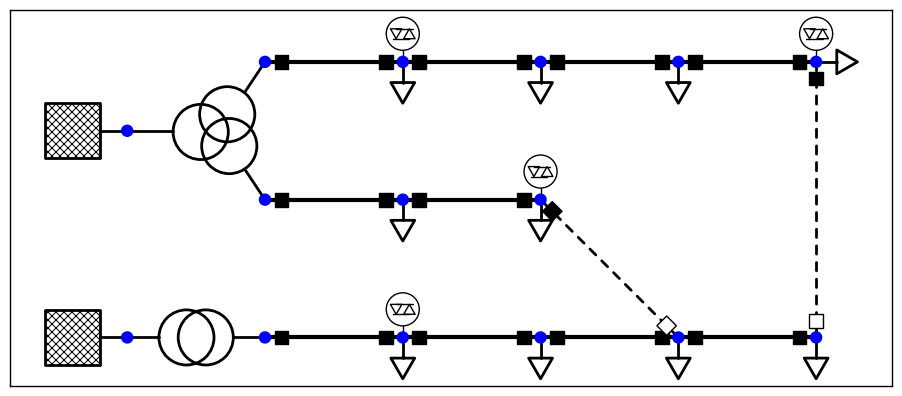

In [15]:
plot_grid(net)